### First test code for 40mhz Domesday Duplicator samples.  (so far so good!)

In [1]:
# Just your usual setup

import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fft8 as fft8 
import ld_utils as utils

import copy

In [2]:
pi = np.pi
tau = np.pi * 2

# Make sure this is a power of two!
blocklenk = 128
blocklen = (blocklenk * 1024)

In [3]:
# System default specs for NTSC and PAL.

NTSC_hz_ire = (9300000 - 7600000) / 140.0 # Later disks may have a higher white point

SysParams_NTSC = {
    'system_name': 'NTSC',
    'analog_audio': True,
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'fsc_mhz': (315.0 / 88.0),

    # video frequencies 
    # per spec, range from -40 to 100 IRE is 1.7mhz, so 12142 ire/mhz
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match 0-65534 scaling
    'ire_min': -60,
    'ire_max': 140,

    # changeable defaults
    #'deemp': (120, 320), # actual deemp timing
    'deemp': (135, 320),

    'vbpf': (3200000, 14000000),
    'vbpf_order': 1,
    
    'ahpf_freq': 3100000,
    'ahpf_order': 1,
    
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 4 # butterworth filter order
}

SysParams_PAL = {
    'system_name': 'PAL',
    'analog_audio': False, # not true for later PAL
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    'fsc_mhz': 4.43361875,

    # video frequencies 
    'videorf_sync': 6760000,
    'videorf_0ire': 7100000,
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 8000000),
    'vbpf_order': 2,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5		# butterworth filter order
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    

In [4]:
# Domesday Duplicator system uses 32mhz/10bit, expressed as 16-bit signed integers
CapParams_DomesdayDuplicator = {
    'freq': 40.0,
    'dtype': np.int16,
}

# cxadc can only really capture at 8fsc (28.8xmhz), with 8-bit unsigned samples
CapParams_cxadc = {
    'freq': (315.0 / 88.0) * 8.00,
    'dtype': np.uint8,
}

try:
    tmp = CapParams['freq']
except:
    CapParams = CapParams_cxadc

In [5]:
CapParams = CapParams_cxadc
CapParams = CapParams_DomesdayDuplicator
SysParams = copy.deepcopy(SysParams_NTSC)

In [6]:
SysParams['vsync_freq'] = 1000000
SysParams['vsync_order'] = 3

In [7]:
OverrideParams = {}

params = {}

for p in [SysParams, CapParams, OverrideParams]:
    for k in p.keys():
        print(k, p[k])
        params[k] = p[k]

system_name NTSC
analog_audio True
audio_lfreq 2301136
audio_rfreq 2812499
fsc_mhz 3.5795454545454546
hz_ire 12142.857142857143
videorf_sync 8585714.285714285
videorf_0ire 8100000
videorf_7.5ire 8191071.428571428
videorf_100ire 9314285.714285715
ire_min -60
ire_max 140
deemp (135, 320)
vbpf (3200000, 14000000)
vbpf_order 1
ahpf_freq 3100000
ahpf_order 1
vlpf_freq 4200000
vlpf_order 4
vsync_freq 1000000
vsync_order 3
freq 40.0
dtype <class 'numpy.int16'>


In [8]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*200+[0]*200)
    #np.fft.ifft([0]+[1]*(blocklen//4)+[0]*(blocklen//4))
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do the 'heavy lifting'
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

# A rather pants attempt at doing an MTF function. This needs to be better.
[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.0)
Fmtf = filtfft([tf_b, tf_a])

# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(SP):
    SP['freq_hz'] = SP['freq'] * 1000000
    
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2
    
    # RF BPF and analog audio cut filters
    SP['ibpf'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'))
    SP['iapf'] = filtfft(sps.butter(SP['ahpf_order'], SP['ahpf_freq']/freq_hz_half, 'high'))
    
    # standard post-demod LPF
    SP['plpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low'))
    SP['psync'] = filtfft(sps.butter(SP['vsync_order'], SP['vsync_freq']/freq_hz_half, 'low'))

    # post-demod deemphasis filter
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    SP['deemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))
    #SP['deemp'] = filtfft([tf_b, tf_a])

    SP['fft_video'] = SP['ibpf'] * fft_hilbert

    if SP['analog_audio'] == True:
        Fcutl = filtfft(sps.butter(1, [(SP['audio_lfreq'] - 750000)/freq_hz_half, (SP['audio_lfreq'] + 750000)/(freq_hz/2)], btype='bandstop'))
        Fcutr = filtfft(sps.butter(1, [(SP['audio_rfreq'] - 750000)/freq_hz_half, (SP['audio_rfreq'] + 750000)/(freq_hz/2)], btype='bandstop'))

        # if AC3:
        #SP['f_arightcut'] = sps.butter(1, [(2650000)/(freq_hz/2), (3150000)/(freq_hz/2)], btype='bandstop')

        SP['fft_video'] *= (Fcutl * Fcutr)
        
    # Post processing:  lowpass filter + deemp
    SP['fft_post'] = SP['plpf'] * SP['deemp']

In [9]:
# The actual video demodulation code
def dodemod(params, data, clip = None, usemtf = False, cutarf = False):
    prepare_video_filters(params)

    data_fft = np.fft.fft(data)
    
    datac = data_fft * params['ibpf']
    if cutarf is True:
        datac *= params['iapf']
    if usemtf is True:
        datac *= Fmtf
    
    datac = np.fft.ifft(datac)
    
    if clip is not None:
        datac = datac.clip(-clip, clip)
    
    data_fft = np.fft.fft(datac)
    hilbert = np.fft.ifft(data_fft * fft_hilbert)

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
            dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    demod = (tdangles2 * (params['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)

    output = np.fft.ifft(demod_fft * params['fft_post']).real
    #output_sync = np.fft.ifft(demod_fft * params['psync']).real
    
    return output


In [10]:
def lineplot(output, param):
    plt.plot(output)
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [11]:
prepare_video_filters(params)

In [13]:
infile = open('ggv1069_colourbars.raw', 'rb')
inbuf = infile.read(1024 * 1024 * 64)
indata = np.fromstring(inbuf, 'int16', len(inbuf) // 2)

data1 = indata[0:blocklen]


In [14]:
indata.min(), indata.max()

(-14016, 14656)

In [16]:
blockcut = 1024

SysParams = copy.deepcopy(SysParams_NTSC)
OverrideParams['vsync_freq'] = 600000
OverrideParams['vsync_order'] = 4

params = {}

36.7913161727


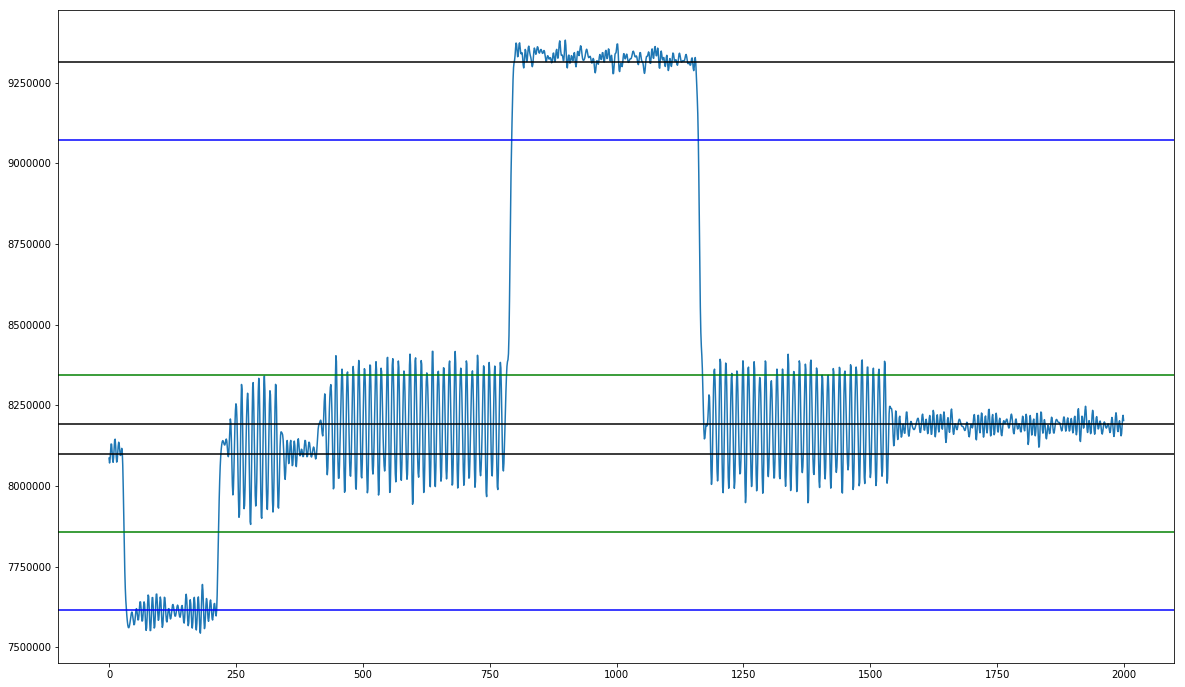

In [37]:
for p in [SysParams, CapParams, OverrideParams]:
    for k in p.keys():
        #print(k, p[k])
        params[k] = p[k]

        adj = 1
params['deemp'] = [100*adj, 320*adj]
params['vbpf'] = (3200000, 12000000)
params['vbpf_order'] = 1

params['ahpf_freq'] = 3100000
params['ahpf_order'] = 2

params['vlpf_freq'] = 4200000
params['vlpf_order'] = 5

output1 = dodemod(copy.deepcopy(params), data1, usemtf=True)
lineplot(output1[40500:42500], params)

calcsnr(output1[41400:41650])

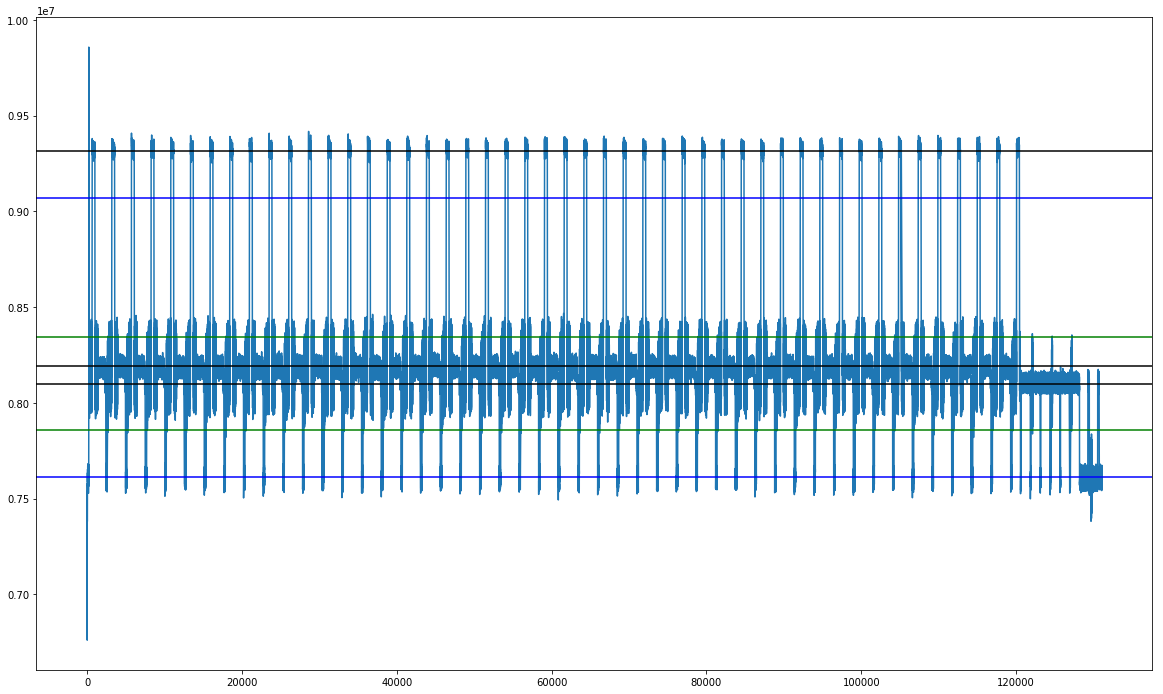

In [34]:
lineplot(output1, params)